In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.sparse import csr_matrix
from scipy.optimize import fsolve, differential_evolution, minimize
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from bachelor_funcs import Σ_initial, c_s2, chi2_fit
from unchanged_values import r, r_au, sD1_log, Ω, T_req

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

In [33]:
### Opacity ###
def tau_R(T, Σ):
    if type(T) != np.ndarray:
        TT = (T.value).copy()
    else:
        TT = T.copy()
    κ = np.zeros_like(TT)

    κ[TT < 150] = 4.5 * (TT[TT < 150] / 150)**2 

    κ[np.where((TT >= 150) & (TT <= 1500))] = 4.5 

    #Defining transition region
    def τ_R_func(T):
        a, b, c = [ 2.25221001e+00,  1.39416392e-02, -1.72380082e+03]
        return a * (1 - np.tanh((T + c) * b))
    
    Trans_i = np.where((TT >= 1500) & (TT <= 2000))
    κ[Trans_i] = τ_R_func(TT[Trans_i])
    
    κ[TT > 2000] = 0 # Støvet fordamper og går i stykker 

    return κ * (Σ.to('g/cm2')).value / 2, Trans_i


def tau_P(τ_R):
    τ_P = τ_R.copy()
    τ_P[2.4 * τ_P <= 0.5] = 0.5
    τ_P[τ_P != 0.5] = 2.4 * τ_P[τ_P != 0.5]
    return τ_P

In [34]:
tau_R(T_req, Σ_initial(r_au))[1]

(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
       dtype=int64),)

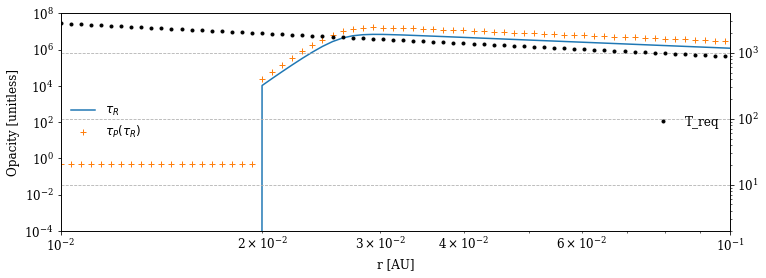

In [44]:
fig, axs = plt.subplots(figsize = (12,4))

axs.loglog(r_au, tau_R(T_req, Σ_initial(r_au))[0], '-', label = f'$τ_R$')
axs.loglog(r_au, tau_P(tau_R(T_req, Σ_initial(r_au))[0]), '+', label = f'$τ_P(τ_R)$')
axs.set(ylabel = 'Opacity [unitless]', xlabel = 'r [AU]', ylim = (1e-4, 1e8), xlim=(1e-2, 1e-1));
plt.legend(frameon = False, loc = 'center left')

axs2 = axs.twinx()

axs2.loglog(r_au, T_req,'.', c = 'black', label = 'T_req')
axs2.grid(ls='--')
axs2.legend(frameon = False, loc = 'center right')

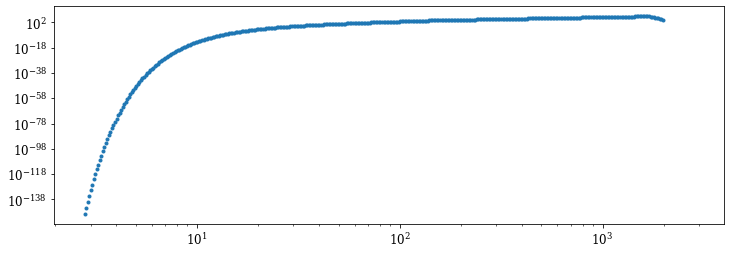

In [36]:
fig, axs = plt.subplots(figsize = (12,4))

axs.loglog(T_req, tau_R(T_req, Σ_initial(r_au))[0], '.', label = f'$τ_R$')


In [37]:
x = np.array([1400, 1500, 1650, 1700, 1800, 1900, 2000,])
y = np.array([4.5, 4.5, 4, 2.5, 1, 0, 0])
sigma_y = np.array([0.01, 0.01, 0.2, 0.2, 0.1, 0.01, 0.01])
def τ_R_func(T, a, b, c):
    return a * (1 - np.tanh((T + c) * b))

In [38]:
fit, value, error, cov, X, Y = chi2_fit(τ_R_func, x, y, sigma_y, np.array([4.5, 1e-2, -1400]))
print(fit, value)

[4.37494009e+01 4.00000000e+00 7.23258779e-09] [ 2.25221001e+00  1.39416392e-02 -1.72380082e+03]


Text(0.5, 0, 'T [K]')

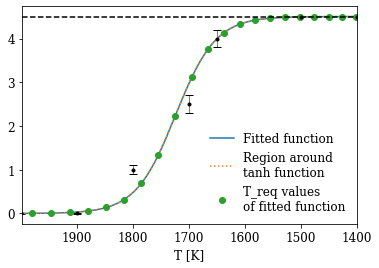

In [39]:
plt.errorbar(x, y, fmt='.', c='black', yerr = sigma_y, capsize = 4, elinewidth = 0.5)
plt.plot(X, Y, label = 'Fitted function')
t = np.arange(x[0], x[-1])

plt.plot(t, τ_R_func(t, *value), ls=':', label = 'Region around\ntanh function')
plt.plot(T_req, τ_R_func(T_req.value, *value), 'o', label = 'T_req values\nof fitted function')
plt.xlim(t[-1], t[0])
plt.axhline(4.5, ls='--', c = 'black')
plt.legend(frameon = False)
plt.xlabel('T [K]')

(1600.0, 1450.0)

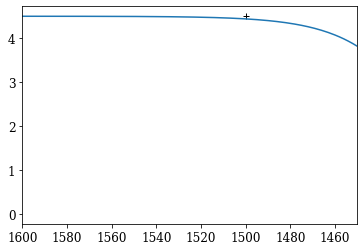

In [40]:
t = np.arange(1400, 1601)
plt.plot(x, y, '+', c='black')
plt.plot(t, 4.5 * np.tanh(40**(-1) * (t - 1400)))
plt.xlim(1600, 1450)

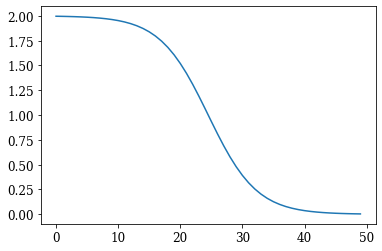

In [41]:
plt.plot(1-np.tanh(np.linspace(- np.pi, np.pi)))